In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv("labeled_data.csv")
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# Convert labels:
# 0,1 → Offensive (1)
# 2 → Non-offensive (0)

df['label'] = df['class'].apply(lambda x: 0 if x == 2 else 1)

df[['tweet', 'label']].head()


,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [6]:
# UPDATE THIS IN YOUR JUPYTER NOTEBOOK
def clean_text(text):
    text = str(text).lower()
    # DELETE the lines that remove stopwords!
    # KEEP "not", "no", "don't" -> These are crucial for hate speech.
    
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text) # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
df['clean_text'] = df['tweet'].apply(clean_text)
df[['tweet', 'clean_text']].head()

,tweet,clean_text
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about clea...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat ho...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she start...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true or...


In [8]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [10]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, SpatialDropout1D

model = Sequential([
    # Embedding: Increased dimension to 200 for richer representation
    Embedding(input_dim=max_words, output_dim=200, input_length=max_len),
    
    # SpatialDropout drops entire 1D feature maps instead of individual elements
    SpatialDropout1D(0.3),
    
    # Bidirectional LSTM: Captures context from both start and end of sentence
    Bidirectional(LSTM(128, return_sequences=True)),
    
    # GlobalMaxPooling reduces dimensionality while keeping the most important features
    GlobalMaxPooling1D(),
    
    # Dense layers for classification
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\A\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Calculate Class Weights to handle imbalance (Crucial for accuracy)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

# Callbacks to stop training when accuracy stops improving
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
]

history = model.fit(
    X_train_pad,
    y_train,
    epochs=15, # Increased epochs, EarlyStopping will cut it short if needed
    batch_size=32, # Smaller batch size often generalizes better
    validation_split=0.2,
    class_weight=class_weights_dict, # Apply weights
    callbacks=callbacks
)

Class Weights: {0: np.float64(2.9768768768768767), 1: np.float64(0.6009335596508244)}
Epoch 1/15
496/496 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.8842 - loss: 0.2604 - val_accuracy: 0.9357 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 2/15
496/496 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9537 - loss: 0.1300 - val_accuracy: 0.9465 - val_loss: 0.1405 - learning_rate: 0.0010
Epoch 3/15
496/496 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9726 - loss: 0.0835 - val_accuracy: 0.9438 - val_loss: 0.1532 - learning_rate: 0.0010
Epoch 4/15
496/496 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9813 - loss: 0.0568 - val_accuracy: 0.9397 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 5/15
496/496 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9900 - loss: 0.0278 - val_accuracy: 0.9413 - val_loss: 0.2597 - learning_rate: 2.0000e-04


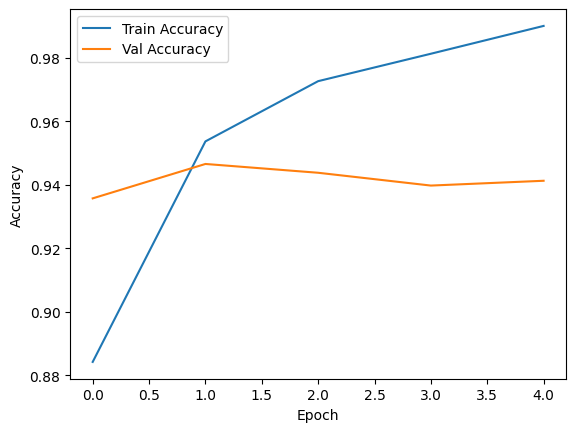

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       833
           1       0.98      0.95      0.97      4124

    accuracy                           0.95      4957
   macro avg       0.89      0.94      0.91      4957
weighted avg       0.95      0.95      0.95      4957



In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 769,   64],
       [ 204, 3920]])

In [19]:
def predict_custom(text):
    # 1. Clean the text (uses your clean_text function)
    cleaned = clean_text(text)
    
    # 2. Convert to sequence
    seq = tokenizer.texts_to_sequences([cleaned])
    
    # 3. Pad the sequence (MUST use same max_len as training)
    padded = pad_sequences(seq, maxlen=100, padding='post') # Ensure maxlen matches your training (100)
    
    # 4. Predict
    pred_prob = model.predict(padded)[0][0]
    
    # 5. Output
    label = "OFFENSIVE" if pred_prob > 0.5 else "NON-OFFENSIVE"
    confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob
    
    print(f"Text: '{text}'")
    print(f"Cleaned: '{cleaned}'")
    print(f"Prediction: {label} ({confidence*100:.2f}%)")
    print("-" * 30)

# --- TEST YOUR SENTENCES HERE ---
predict_custom("You are a bad person")
predict_custom("You are not good person") 
predict_custom("I hate you")
predict_custom("you are a bitch")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: 'You are a bad person'
Cleaned: 'you are a bad person'
Prediction: NON-OFFENSIVE (91.78%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Text: 'You are not good person'
Cleaned: 'you are not good person'
Prediction: NON-OFFENSIVE (93.40%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Text: 'I hate you'
Cleaned: 'i hate you'
Prediction: OFFENSIVE (54.86%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: 'you are a bitch'
Cleaned: 'you are a bitch'
Prediction: OFFENSIVE (99.92%)
------------------------------


In [15]:
import pickle

# 1. Save the Keras Model
model.save("hate_speech_model.h5")

# 2. Save the Tokenizer (Crucial for converting text to numbers correctly)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Artifacts saved successfully.")

Artifacts saved successfully.
